In [5]:
#First import the libraries
from riotwatcher import LolWatcher, RiotWatcher, ApiError 
from dotenv import dotenv_values
import pandas as pd

In [54]:
#now load the API keys from the config file
def setup_env():
    '''Load the API keys from the config file''' #this is called a docstring and will show in some editors when you start typing the function name
    api_key = dotenv_values("../config.env")['DEV_KEY']
    lol_watcher = LolWatcher(api_key) #for league of legends specific calls
    riot_watcher = RiotWatcher(api_key) #for all Riot games
    
    return lol_watcher, riot_watcher

lol_watcher, riot_watcher= setup_env()

In [55]:
#Let's think about this: first we need to set the REGION + QUEUE and pull the challenger players
player_region= 'NA1'.lower() #[BR1, EUN1, EUW1, JP1, KR, LA1, LA2, NA1, OC1, TR1, RU] https://developer.riotgames.com/docs/lol#routing-values_platform-routing-values
player_routing= 'americas' #https://developer.riotgames.com/docs/lol#routing-values_regional-routing-values

queue_type= 'RANKED_SOLO_5x5' #acceptable parameters are [RANKED_SOLO_5x5, RANKED_FLEX_SR, RANKED_FLEX_TT], see https://developer.riotgames.com/apis#league-v4/GET_getChallengerLeague
#for gamemode list see: https://static.developer.riotgames.com/docs/lol/gameModes.json

In [6]:
#Now we can pull the challenger ladder
challenger_ladder= lol_watcher.league.challenger_by_queue(region= player_region, queue=queue_type) #returns LeagueListDTO

# What is in challenger_ladder? you can read the info on https://developer.riotgames.com/apis#league-v4/GET_getChallengerLeague
raw_data= pd.DataFrame.from_dict(challenger_ladder) 
print(raw_data.head()) #print the first few rows to see what the data looks like
print('Fields= ', list(raw_data)) 

         tier                              leagueId            queue  \
0  CHALLENGER  7941a1fa-7574-30d5-af8e-7d8990a94a20  RANKED_SOLO_5x5   
1  CHALLENGER  7941a1fa-7574-30d5-af8e-7d8990a94a20  RANKED_SOLO_5x5   
2  CHALLENGER  7941a1fa-7574-30d5-af8e-7d8990a94a20  RANKED_SOLO_5x5   
3  CHALLENGER  7941a1fa-7574-30d5-af8e-7d8990a94a20  RANKED_SOLO_5x5   
4  CHALLENGER  7941a1fa-7574-30d5-af8e-7d8990a94a20  RANKED_SOLO_5x5   

                  name                                            entries  
0  Cho'Gath's Rageborn  {'summonerId': 'OGIq-zVP13lFTK0ymE5ocHhZDIjjl7...  
1  Cho'Gath's Rageborn  {'summonerId': 'ER7vWiY9wha3h5znGge2QDoAxLAxaP...  
2  Cho'Gath's Rageborn  {'summonerId': 'rdR35LroSISyYJylbUrFIg9UAkUlfb...  
3  Cho'Gath's Rageborn  {'summonerId': 'GKTy6Pt9PArBrzHg1STx-yGiY-xmVI...  
4  Cho'Gath's Rageborn  {'summonerId': '2SROoDaaN6MicBX6v0wQmGmYnc0Tzd...  
Fields=  ['tier', 'leagueId', 'queue', 'name', 'entries']


In [8]:
challenger_players= pd.DataFrame.from_dict(challenger_ladder['entries']) #we only really care about the entries
print('Fields= ', list(challenger_players))

Fields=  ['summonerId', 'puuid', 'leaguePoints', 'rank', 'wins', 'losses', 'veteran', 'inactive', 'freshBlood', 'hotStreak']


In [24]:
#so for each item in challenger_players we can pull the player info by passing the puuid to /lol/league/v4/entries/by-puuid/{encryptedPUUID}
#Let's walkthrough this with a single player before converting this to a funtion

#puuid of first player is challenger_players.iloc[0]['puuid']
last_match_id= lol_watcher.match.matchlist_by_puuid(region= player_region, puuid= challenger_players.iloc[0]['puuid'])[0] #now return the match ID of the last game
print('Last match ID= ', last_match_id)

Last match ID=  NA1_5240086654


In [30]:
# Let's get the match details
# Get match details using last_match_id
match_details = lol_watcher.match.by_id(region=player_routing, match_id=last_match_id)

# Extract participant information
participants = match_details['info']['participants']

# Find the participant with the matching puuid
player_puuid = challenger_players.iloc[0]['puuid']
player_info = next(participant for participant in participants if participant['puuid'] == player_puuid)

# Get the lane and role played by the player
player_lane = player_info['lane']
player_role = player_info['role']
print(f"Lane and role played by the player in the first row: {player_lane} - {player_role}")


Lane and role played by the player in the first row: TOP - SOLO


In [32]:
#and scale it up to get the last 10 games
from collections import Counter

# Get the puuid of the first player
player_puuid = challenger_players.iloc[0]['puuid']

# Get the 5 most recent match IDs
recent_match_ids = lol_watcher.match.matchlist_by_puuid(region=player_routing, puuid=player_puuid)[:10]

# Initialize a list to store lane and role combinations
lane_role_combinations = []

# Loop through each match ID and get the lane and role
for match_id in recent_match_ids:
    match_details = lol_watcher.match.by_id(region=player_routing, match_id=match_id)
    participants = match_details['info']['participants']
    player_info = next(participant for participant in participants if participant['puuid'] == player_puuid)
    lane = player_info['lane']
    role = player_info['role']
    lane_role_combinations.append((lane, role))
    print(f"Match ID: {match_id} - Lane: {lane}, Role: {role}")

# Find the most common lane and role combination
most_common_combination = Counter(lane_role_combinations).most_common(1)[0]
print(f"Most common lane and role combination: {most_common_combination[0]} - Count: {most_common_combination[1]}")

Match ID: NA1_5240086654 - Lane: TOP, Role: SOLO
Match ID: NA1_5237050591 - Lane: TOP, Role: SOLO
Match ID: NA1_5237026250 - Lane: BOTTOM, Role: CARRY
Match ID: NA1_5237000800 - Lane: TOP, Role: SOLO
Match ID: NA1_5236983225 - Lane: NONE, Role: SUPPORT
Match ID: NA1_5236964405 - Lane: NONE, Role: SUPPORT
Match ID: NA1_5236931393 - Lane: TOP, Role: SOLO
Match ID: NA1_5236895508 - Lane: MIDDLE, Role: DUO
Match ID: NA1_5235709045 - Lane: TOP, Role: SOLO
Match ID: NA1_5233624404 - Lane: TOP, Role: SOLO
Most common lane and role combination: ('TOP', 'SOLO') - Count: 6


In [42]:
from collections import Counter

# Function to get the most common lane and role combination for a player
def get_most_common_lane_role(player_puuid):
    #get last N games
    recent_match_ids = lol_watcher.match.matchlist_by_puuid(region=player_routing, puuid=player_puuid)[:3]
    lane_role_combinations = []

    for match_id in recent_match_ids:
        match_details = lol_watcher.match.by_id(region=player_routing, match_id=match_id)
        participants = match_details['info']['participants']
        player_info = next(participant for participant in participants if participant['puuid'] == player_puuid)
        lane = player_info['lane']
        role = player_info['role']
        #bot laners require additional clarification
        if role == 'CARRY':
            lane = 'ADC'
        elif role == 'SUPPORT':
            lane = 'SUPPORT'
        lane_role_combinations.append((lane, role))

    most_common_combination = Counter(lane_role_combinations).most_common(1)[0]
    return most_common_combination, len(recent_match_ids)

# Function to get the player's gameName and tagLine
def get_player_name(player_puuid):
    account_info = riot_watcher.account.by_puuid(region=player_routing, puuid=player_puuid)
    return f"{account_info['gameName']}#{account_info['tagLine']}"

# Initialize a list to store the results
results = []

# Iterate over the first n rows of challenger_players
for index, row in challenger_players.head(10).iterrows():
    #remove the .head(n) to get all the players
    player_puuid = row['puuid']
    player_name = get_player_name(player_puuid)
    most_common_combination, total_games = get_most_common_lane_role(player_puuid)
    percentage = most_common_combination[1] / total_games
    results.append({
        'Player': player_name,
        'Most Common Lane': most_common_combination[0][0],
        'Most Common Role': most_common_combination[0][1],
        'Percentage': f"{percentage:.2f}"
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

                Player Most Common Lane Most Common Role Percentage
0  notscaredtolose#123              TOP             SOLO       0.67
1      never type#1998              ADC            CARRY       0.33
2       ToastyAlex#NA1          Support          SUPPORT       1.00
3      Pentaless#penta          Support          SUPPORT       0.67
4           Cupic#Hwei          Support          SUPPORT       1.00
5            Will#NA12           JUNGLE             NONE       1.00
6          TFBlade#122              TOP              DUO       0.33
7            T0mio#NA1           JUNGLE             NONE       0.67
8        DARKWINGS#NA3              ADC            CARRY       0.33
9          dusklol#000           JUNGLE             NONE       0.67


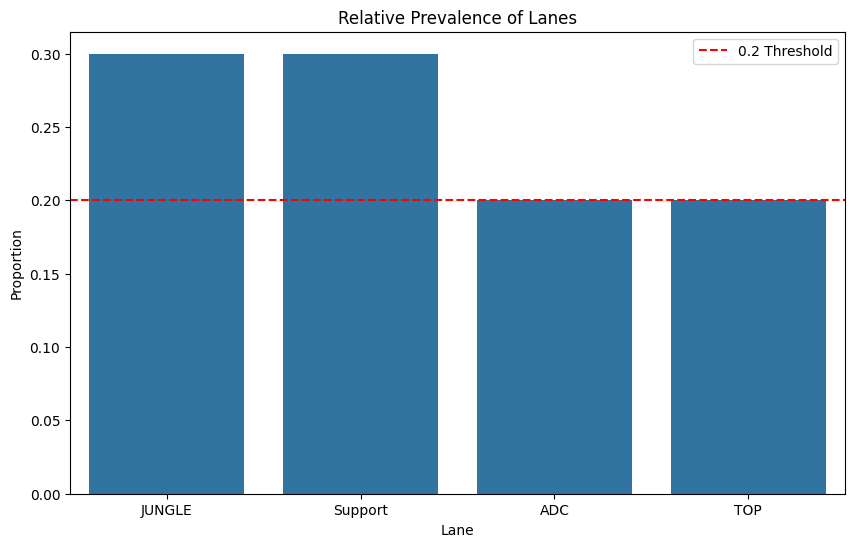

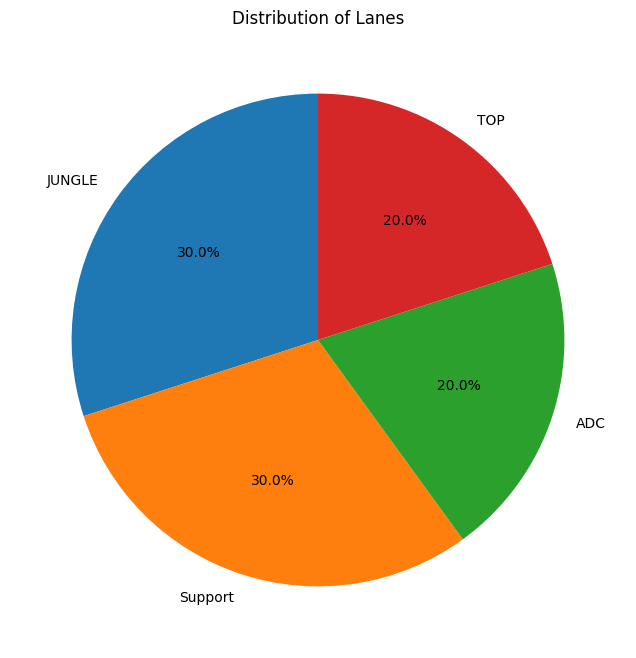

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the lanes from the results DataFrame
lanes = results_df['Most Common Lane']

# Calculate the relative prevalence of each lane
lane_counts = lanes.value_counts(normalize=True)

# Create a bar plot for the relative prevalence of lanes
plt.figure(figsize=(10, 6))
sns.barplot(x=lane_counts.index, y=lane_counts.values)
plt.axhline(0.2, color='red', linestyle='--', label='0.2 Threshold')
plt.title('Relative Prevalence of Lanes')
plt.xlabel('Lane')
plt.ylabel('Proportion')
plt.legend()
plt.show()

# Create a pie chart for the distribution of lanes
plt.figure(figsize=(8, 8))
lane_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Lanes')
plt.ylabel('')
plt.show()

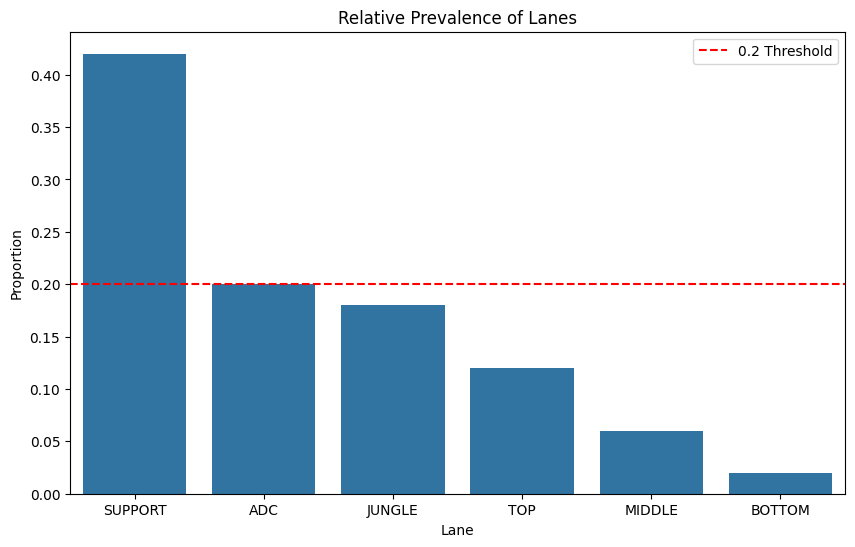

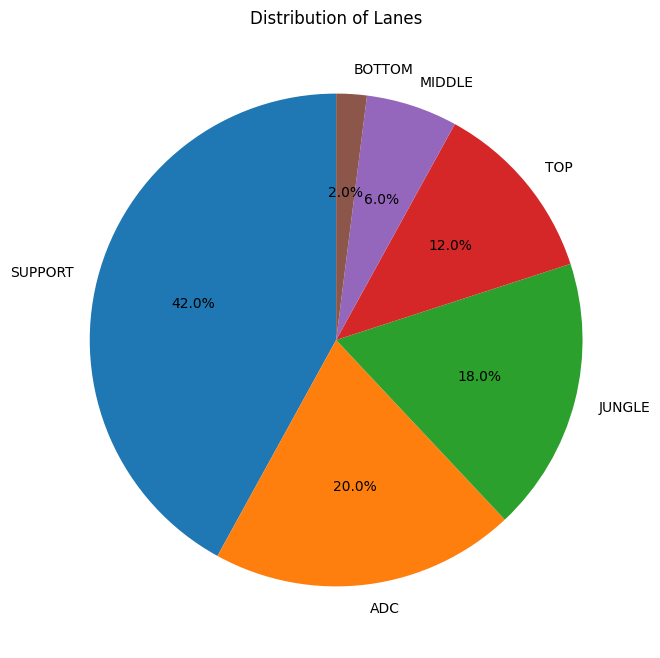

In [56]:
from riotwatcher import LolWatcher, RiotWatcher, ApiError 
from dotenv import dotenv_values
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def get_most_common_lane_role(player_puuid, num_matches=5):
    """Get player's most common lane/role from recent matches"""
    matches = lol_watcher.match.matchlist_by_puuid(region=player_routing, puuid=player_puuid)[:num_matches]
    lane_roles = []
    
    for match_id in matches:
        match = lol_watcher.match.by_id(region=player_routing, match_id=match_id)
        player = next(p for p in match['info']['participants'] if p['puuid'] == player_puuid)
        lane = 'ADC' if player['role'] == 'CARRY' else 'SUPPORT' if player['role'] == 'SUPPORT' else player['lane']
        lane_roles.append((lane, player['role']))
    
    return Counter(lane_roles).most_common(1)[0], len(matches)

def analyze_challenger_players(num_players=75):
    """Analyze lane distribution among challenger players"""
    results = []
    
    for _, player in challenger_players.head(num_players).iterrows():
        account = riot_watcher.account.by_puuid(region=player_routing, puuid=player['puuid'])
        common_role, games = get_most_common_lane_role(player['puuid'])
        
        results.append({
            'Player': f"{account['gameName']}#{account['tagLine']}",
            'Most Common Lane': common_role[0][0],  # Unpack lane from tuple
            'Most Common Role': common_role[0][1],  # Unpack role from tuple
            'Percentage': f"{common_role[1]/games:.2f}"
        })
    
    return pd.DataFrame(results)

def plot_lane_distribution(results_df):
    """Create visualization for lane distribution"""
    lane_counts = results_df['Most Common Lane'].value_counts(normalize=True)
    
    # Bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=lane_counts.index, y=lane_counts.values)
    plt.axhline(0.2, color='red', linestyle='--', label='0.2 Threshold')
    plt.title('Relative Prevalence of Lanes')
    plt.xlabel('Lane'), plt.ylabel('Proportion')
    plt.legend()
    plt.show()
    
    # Pie chart
    plt.figure(figsize=(8, 8))
    lane_counts.plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Lanes')
    plt.ylabel('')
    plt.show()

# Execute analysis
results_df = analyze_challenger_players()
plot_lane_distribution(results_df)
